# 함수형 API 다중입출력모델

In [2]:
from tensorflow import keras
from keras import Input
from keras.layers import Dense
from keras.layers import Concatenate
from keras.models import Model
import numpy as np

2025-11-06 02:46:33.326581: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-06 02:46:33.383033: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/dist

## 1. 데이터 준비

-- 입력 데이터 --  
- 이슈 티켓의 제목 (텍스트)  
- 이슈 티켓의 텍스트 본문 (텍스트)  
- 사용자가 추가한 태그 (범주에서 선택 (multi-hot 인코딩되었다고 가정))

In [ ]:
vocab_size = 10000
num_tags = 100	
num_departments = 4
num_samples = 1280

In [4]:
title_data = np.random.randint(0,2, size=(num_samples, vocab_size))
text_body_data = np.random.randint(0,2, size=(num_samples, vocab_size))
tags_data = np.random.randint(0,2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0,2, size=(num_samples, num_departments))

## 2. 모델 설계

### 2-1. Input Layer 정의

In [5]:
title = Input(shape=(vocab_size,), name="title")
text_body = Input(shape=(vocab_size,), name="text_body")
tags = Input(shape=(num_tags,), name="tags")

### 2-2. Hidden Layer 정의

In [ ]:
feature1 = Dense(128, activation="relu")(title)
feature2 = Dense(128, activation="relu")(text_body)

features = Concatenate()([feature1, feature2, tags])
features = Dense(1024, activation="relu")(features)

p_feature = Dense(128, activation="relu")(features)
d_feature = Dense(128, activation="relu")(features)
d_feature = Dense(128, activation="relu")(d_feature)

W0000 00:00:1762397196.250408   68013 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### 2-3. Output Layer 정의

In [7]:
priority = Dense(1, activation="sigmoid", name="priority")(p_feature)
department = Dense(num_departments, activation="softmax", name="department")(d_feature)

### 2-4. 모델 객체 생성

In [8]:
model = Model(inputs=[title, text_body, tags], outputs=[priority, department])

## 3. 모델 학습

### 3-1. 모델 컴파일

In [9]:
model.compile(loss=["mse", "categorical_crossentropy"], optimizer="rmsprop", metrics=[["mae"],["accuracy"]])

### 3-2. 모델 학습

In [10]:
history = model.fit([title_data, text_body_data, tags_data],
		  [priority_data, department_data],
		   epochs=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - department_accuracy: 0.2492 - department_loss: 14499.7656 - loss: 14500.0879 - priority_loss: 0.3219 - priority_mae: 0.4928


## 4. 모델 평가

In [11]:
e = model.evaluate([title_data, text_body_data, tags_data],
		  [priority_data, department_data])

print(e)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - department_accuracy: 0.1164 - department_loss: 78651.1953 - loss: 78651.5312 - priority_loss: 0.3259 - priority_mae: 0.4970
[78651.53125, 0.3258831202983856, 78651.1953125, 0.11640624701976776, 0.49704328179359436]


## 5. 모델 추론

In [12]:
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])
print(priority_preds)
print(department_preds)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


## 6. 모델 시각화

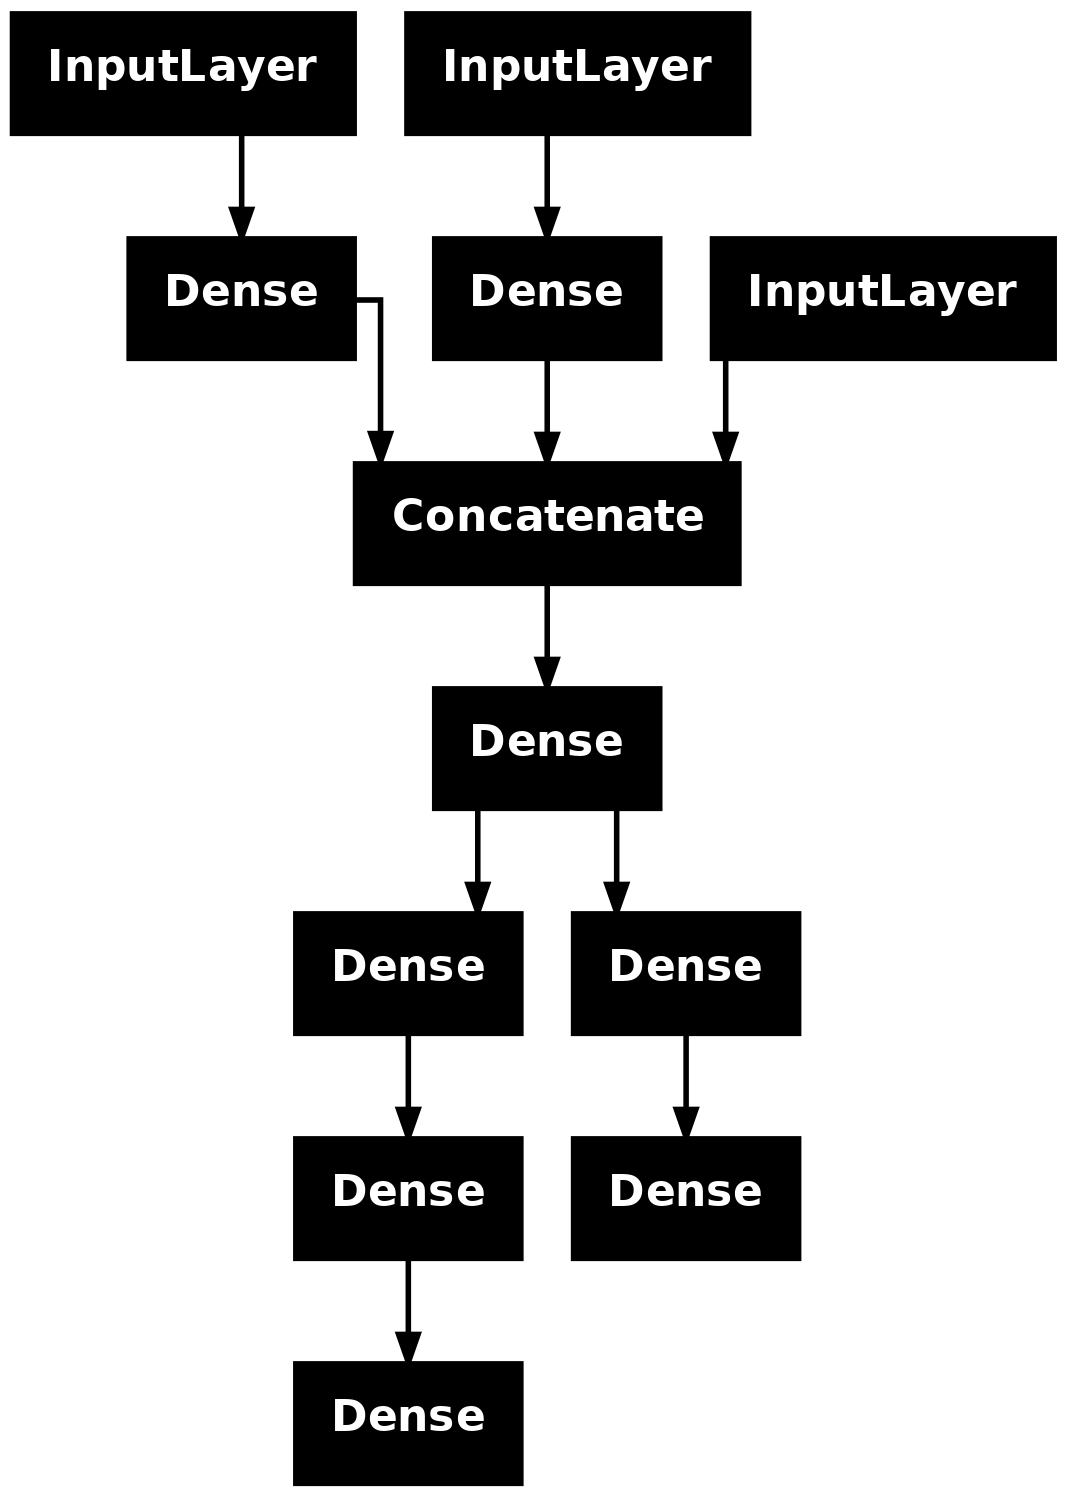

In [13]:
keras.utils.plot_model(model, "assign_model.png")